# Coastal flood hazard for displacement risk modelling

This tutorial shows how to use the coastal flood hazard return periods maps.

Technical specifications for the flood maps.

**Flood map:**  
Resolution: 1000m x 1000m (approximately)  
Horizontal coordinate System: EPSG:4326 - WGS84.  
Nodata value: None.  

The data is single-banded, where each pixel value denotes the depth of the water in meters.  
*** NOTE: Best way to visualize is to clip the raster values from 0.01m to 100m. This will remove 0 values.

**Representative concentration pathways (RCP) considered for sea level rise:** RCP2.6, RCP4.5, RCP8.5  
**Future years considered for sea level rise:** 2020, 2050, 2100.  
**Return periods considered for flood maps:** 1,10,25,50,100,250,1000.   

The superfolder specifies the name of our DEM, namely venDEM. venDEM_scaled_1km implies that flood computation was done on finer (30m resolution), after which maps were rescaled to 1km (approximately).  
The set of flood maps are partitioned into unit latitude-longitude square tiles inside the superfolder.  
For example, S02E040 represents the latitude-longitude tile with bottom left corner at latitude -2 (2S) and longitude 40 (40E).

In each folder, there is then a combination of RCP and year, and within each RCP_year folder, there is one tif file per return period for the latitude-longitude tile.

In [1]:
import os
import pandas as pd
import numpy as np

os.chdir('/Users/simonameiler/Documents/WCR/Displacement/global-displacement-risk') # change back to root folder, not "~/doc"
import coastal_flood_hazard, exposure, vulnerability

Select latitude-longitude tiles for country of interest only.

First, load exposure and get lat/lon max/mins from it.  
Then load the respective flood tiles.

## Load exposure from BEM

In [2]:
from climada.entity.exposures import Exposures

In [3]:
cntry_name = 'Taiwan'

In [4]:
# Load the full dataframe, without further re-aggregation / processing other than adding centroids
gdf_bem_subcomps = exposure.gdf_from_bem_subcomps(cntry_name, opt='full')
gdf_bem_subcomps.head()

,id_1x,iso3,cpx,sector,se_seismo,valhum,valfis,bd_1_floor,bd_2_floor,bd_3_floor,geometry
0,157348471,TWN,3,beds_priv,W,0.003311,0.000035,51.785,48.215,0.0,POINT (118.42083 24.47917)
1,157348471,TWN,3,beds_priv,UFB,0.006622,0.000070,51.785,48.215,0.0,POINT (118.42083 24.47917)
2,157348471,TWN,3,beds_priv,S4M,0.005519,0.000059,51.785,48.215,0.0,POINT (118.42083 24.47917)
3,157348471,TWN,3,beds_priv,S4L,0.001656,0.000018,51.785,48.215,0.0,POINT (118.42083 24.47917)
4,157348471,TWN,3,beds_priv,S4H,0.014900,0.000158,51.785,48.215,0.0,POINT (118.42083 24.47917)


In [6]:
# filter and apply impf id
gdf_bem_subcomps = gdf_bem_subcomps[gdf_bem_subcomps.valhum>0.001] # filter out rows with basically no population
gdf_bem_subcomps['impf_FL'] = gdf_bem_subcomps.apply(lambda row: vulnerability.DICT_PAGER_FLIMPF_IVM[row.se_seismo], axis=1)

In [7]:
# replace impf 3 --> 5 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==3), "impf_FL"] = 5

In [8]:
# replace impf 4 --> 6 for 2-storeys and more
gdf_bem_subcomps.loc[((gdf_bem_subcomps.bd_3_floor+gdf_bem_subcomps.bd_2_floor)>0.5)
                     &(gdf_bem_subcomps.impf_FL==4), "impf_FL"] = 6

In [9]:
# remove for now unnecessary cols and prepare gdf for CLIMADA Exposure
gdf_bem_subcomps.rename({'valhum' : 'value'}, axis=1)
for col in ['iso3', 'sector', 'valfis', 'se_seismo']:
    gdf_bem_subcomps.pop(col)

In [10]:
gdf_bem_subcomps

,id_1x,cpx,valhum,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL
0,157348471,3,0.003311,51.785,48.215,0.0,POINT (118.42083 24.47917),2
1,157348471,3,0.006622,51.785,48.215,0.0,POINT (118.42083 24.47917),6
2,157348471,3,0.005519,51.785,48.215,0.0,POINT (118.42083 24.47917),6
3,157348471,3,0.001656,51.785,48.215,0.0,POINT (118.42083 24.47917),6
4,157348471,3,0.014900,51.785,48.215,0.0,POINT (118.42083 24.47917),6
...,...,...,...,...,...,...,...,...
3273603,158350866,3,0.822684,100.000,0.000,0.0,POINT (120.85417 24.32083),4
3273604,158350866,3,12.040214,100.000,0.000,0.0,POINT (120.85417 24.32083),4
3273605,158350866,3,9.269118,100.000,0.000,0.0,POINT (120.85417 24.32083),4
3273606,158350866,3,10.598743,100.000,0.000,0.0,POINT (120.85417 24.32083),4


In [11]:
gdf_bem_subcomps.valhum.sum()

39516193.662300505

In [12]:
exp = Exposures(gdf_bem_subcomps)
exp.gdf.rename({'valhum': 'value'}, axis=1, inplace=True)
exp.value_unit = 'Pop. count'
exp.gdf['longitude'] = exp.gdf.geometry.x
exp.gdf['latitude'] = exp.gdf.geometry.y
exp.gdf = exp.gdf[~np.isnan(
    exp.gdf.latitude)]  # drop nan centroids
exp.gdf.head()

,id_1x,cpx,value,bd_1_floor,bd_2_floor,bd_3_floor,geometry,impf_FL,longitude,latitude
0,157348471,3,0.003311,51.785,48.215,0.0,POINT (118.42083 24.47917),2,118.420833,24.479167
1,157348471,3,0.006622,51.785,48.215,0.0,POINT (118.42083 24.47917),6,118.420833,24.479167
2,157348471,3,0.005519,51.785,48.215,0.0,POINT (118.42083 24.47917),6,118.420833,24.479167
3,157348471,3,0.001656,51.785,48.215,0.0,POINT (118.42083 24.47917),6,118.420833,24.479167
4,157348471,3,0.014900,51.785,48.215,0.0,POINT (118.42083 24.47917),6,118.420833,24.479167


#### Get lat/lon min/max from exposure

In [13]:
lat_min, lat_max, lon_min, lon_max = exp.gdf['latitude'].min(), exp.gdf['latitude'].max(), exp.gdf['longitude'].min(), exp.gdf['longitude'].max()

In [14]:
lat_min, lat_max, lon_min, lon_max

(21.912500005759863, 25.27916667242634, 118.28749999999884, 122.00416666666847)

## Load hazard maps for all tiles covering the lat/lon extent of exposure

In [15]:
from climada.util.constants import SYSTEM_DIR
hazard_dir = SYSTEM_DIR/"hazard"/"coastal_flood"/"venDEM_scaled_1km"

In [16]:
# get tiles covering the exposure extent
tiles = coastal_flood_hazard.find_tiles(lat_min, lat_max, lon_min, lon_max)

In [17]:
tiles

['N21E118',
 'N21E119',
 'N21E120',
 'N21E121',
 'N21E122',
 'N22E118',
 'N22E119',
 'N22E120',
 'N22E121',
 'N22E122',
 'N23E118',
 'N23E119',
 'N23E120',
 'N23E121',
 'N23E122',
 'N24E118',
 'N24E119',
 'N24E120',
 'N24E121',
 'N24E122',
 'N25E118',
 'N25E119',
 'N25E120',
 'N25E121',
 'N25E122']

In [18]:
CF_haz_2020 = coastal_flood_hazard.generate_hazard_object(tiles, hazard_dir, 'RCP45', '2020', 'FL')

Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E118/RCP45_2020 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E119/RCP45_2020 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E118/RCP45_2020 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E122/RCP45_2020 not found, skipping...


<GeoAxes: title={'center': 'FL max intensity at each point'}>

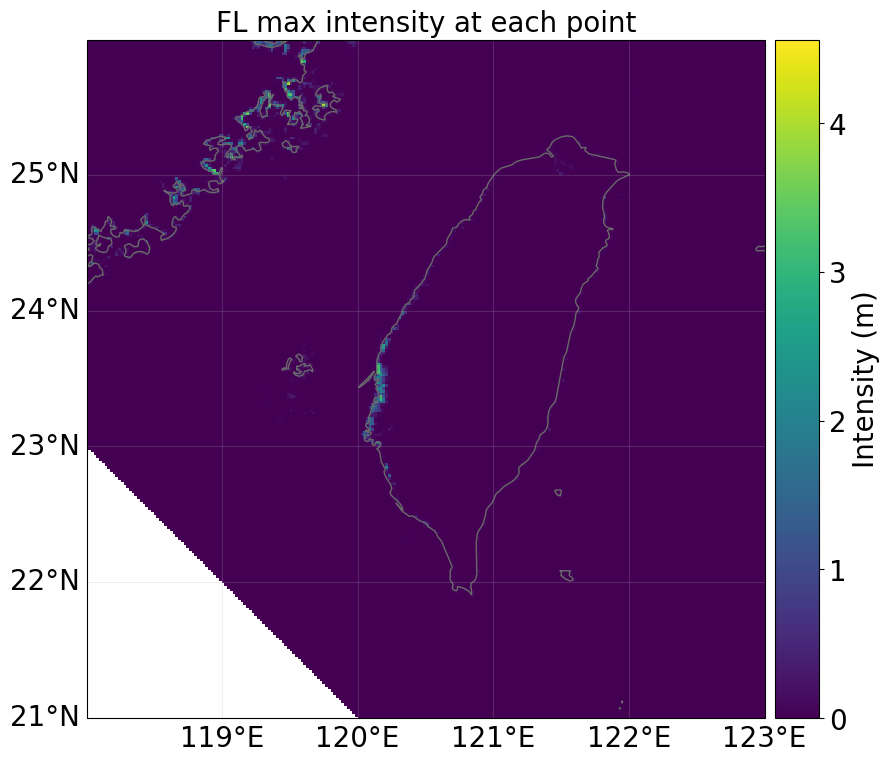

In [19]:
CF_haz_2020.plot_intensity(event=0)

In [21]:
CF_haz_2020.intensity.max(axis=1).data

array([0.18404959, 0.20240587, 0.20997246, 0.21943067, 0.22902663,
       0.2480349 , 0.2768136 , 0.23667584, 0.26010102, 0.2712672 ,
       0.28339761, 0.30050504, 0.32828283, 0.3647934 , 2.7132783 ,
       2.7971258 , 2.8304868 , 2.8620477 , 2.9004223 , 2.9884665 ,
       3.0938292 , 0.2664463 , 0.29206613, 0.30231404, 0.312562  ,
       0.3280808 , 0.35379246, 0.39235997, 0.40466484, 0.4440496 ,
       0.4612305 , 0.47524333, 0.490753  , 0.5109826 , 0.54022956,
       3.926134  , 4.0356383 , 4.104389  , 4.181396  , 4.2732325 ,
       4.392507  , 4.5593204 , 0.303719  , 0.32975206, 0.3442149 ,
       0.35578513, 0.37604225, 0.40805325, 0.4579155 , 2.7135537 ,
       2.9995868 , 3.1471167 , 3.2976124 , 3.5200367 , 3.7879522 ,
       4.1540313 , 0.9213774 , 1.0125988 , 1.0507255 , 1.0840404 ,
       1.1243159 , 1.192011  , 1.3097337 , 0.4214876 , 0.47107437,
       0.5096419 , 0.54545456, 0.93266296, 1.1163086 , 1.3328466 ,
       0.62514234, 0.6908999 , 0.73034894, 0.77307624, 0.83334

In [22]:
CF_haz_2050 = coastal_flood_hazard.generate_hazard_object(tiles, hazard_dir, 'RCP45', '2050', 'FL')

Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E118/RCP45_2050 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E119/RCP45_2050 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E118/RCP45_2050 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E122/RCP45_2050 not found, skipping...


<GeoAxes: title={'center': 'FL max intensity at each point'}>

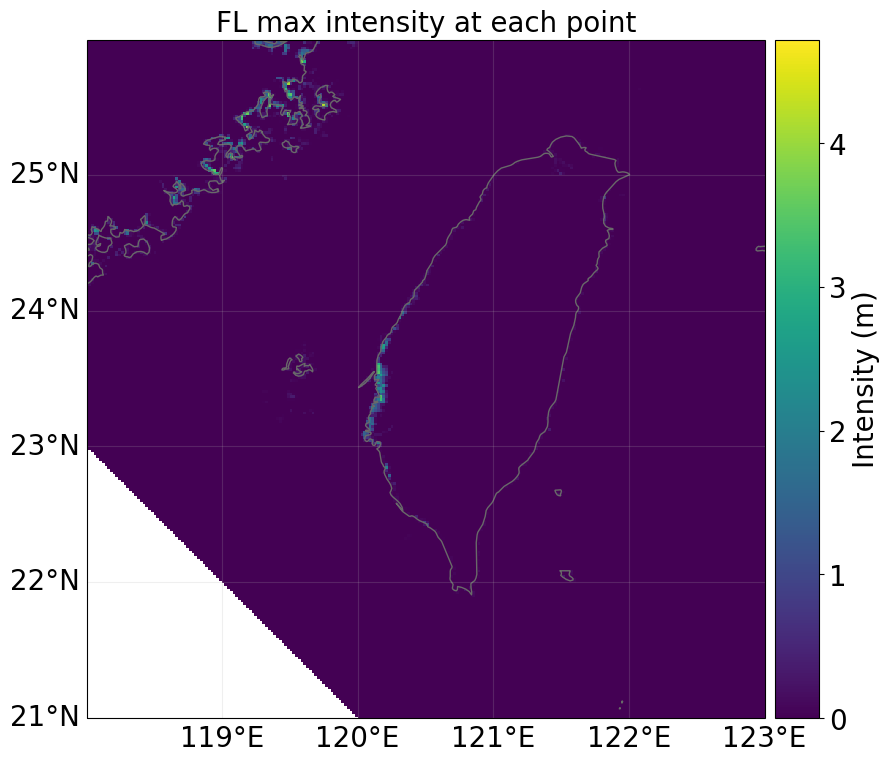

In [23]:
CF_haz_2050.plot_intensity(event=0)

In [24]:
CF_haz_2100 = coastal_flood_hazard.generate_hazard_object(tiles, hazard_dir, 'RCP45', '2100', 'FL')

Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E118/RCP45_2100 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N21E119/RCP45_2100 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E118/RCP45_2100 not found, skipping...
Tile directory /Users/simonameiler/climada/data/hazard/coastal_flood/venDEM_scaled_1km/N22E122/RCP45_2100 not found, skipping...


<GeoAxes: title={'center': 'FL max intensity at each point'}>

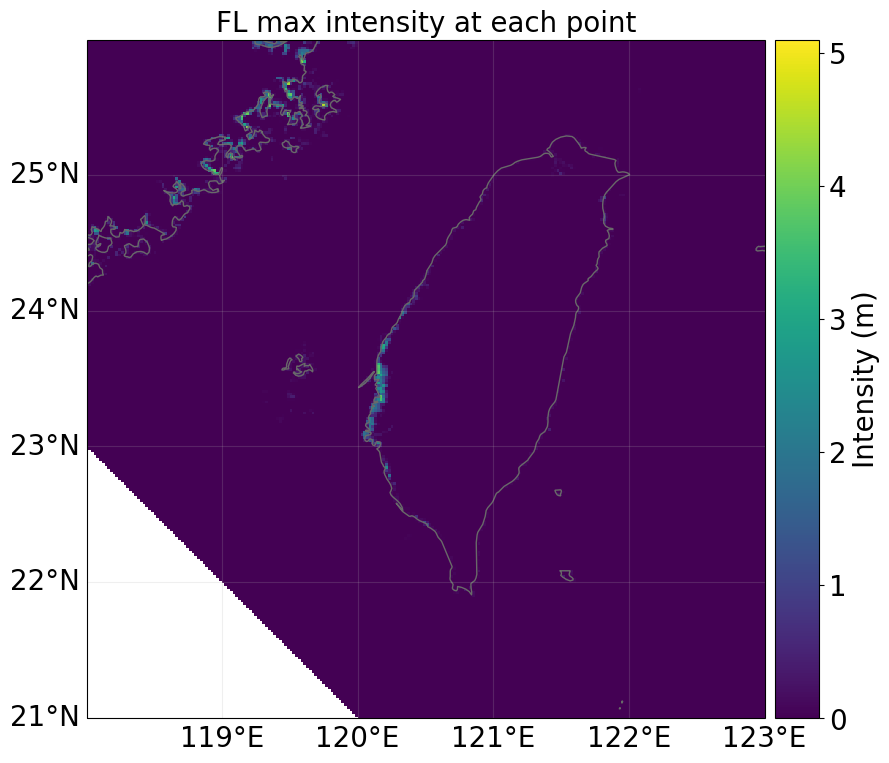

In [25]:
CF_haz_2100.plot_intensity(event=0)

In [26]:
CF_haz_2050.intensity

<147x254100 sparse matrix of type '<class 'numpy.float32'>'
	with 40422 stored elements in Compressed Sparse Row format>

In [30]:
CF_haz_2020.frequency.size

147

In [31]:
CF_haz_2020.event_id

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147])

### Question:
Is it a problem that event_id and event_name are "sanitized" and that intensity crs matrices are stacked vertically during the concat/append routine when calling `generate_hazard_object`?

## Impact functions

In [34]:
impf_set_fl = vulnerability.IMPF_SET_FL_IVM

In [35]:
from climada.entity import ImpactFunc, ImpactFuncSet
impf_set_ivm_step = ImpactFuncSet()

In [36]:
# The threshold of building damage after which all people are displaced. Below, no-one is displaced.
building_thes = 0.55 # 55% iDMC v1; CIMA: 30% for Somalia to 60% for other countries. 

for imp_id in impf_set_fl.get_ids(haz_type='FL'):
    impf_set_fl.get_func(fun_id=imp_id)
    y = impf_set_fl.get_func(fun_id=imp_id)[0].intensity
    x = impf_set_fl.get_func(fun_id=imp_id)[0].mdd
    flood_thres = np.interp(building_thes, x, y)
    print('ID: '+str(imp_id)+' - threshold stepfunction: '+str(flood_thres))
    impf_set_ivm_step.append(
                ImpactFunc.from_step_impf(
                    intensity=(0,  flood_thres, flood_thres *10),
                    haz_type='FL',
                    impf_id=imp_id,
                    intensity_unit = 'm'
                )
    )

ID: 1 - threshold stepfunction: 0.5625
ID: 2 - threshold stepfunction: 0.7000000000000002
ID: 3 - threshold stepfunction: 1.0
ID: 5 - threshold stepfunction: 1.8125000000000004
ID: 4 - threshold stepfunction: 1.5
ID: 6 - threshold stepfunction: 3.0


### Impacts

In [41]:
from climada.engine import ImpactCalc

impcalc = ImpactCalc(exp, impf_set_ivm_step, CF_haz_2100)
impact = impcalc.impact()

In [42]:
print('Annual average displacement: ' + "{:,.0f}".format(impact.aai_agg))

Annual average displacement: 7,659


In [48]:
freqd_curve = impact.calc_freq_curve()

<Axes: title={'center': 'Exceedance frequency curve'}, xlabel='Return period (year)', ylabel='Impact (Pop. count)'>

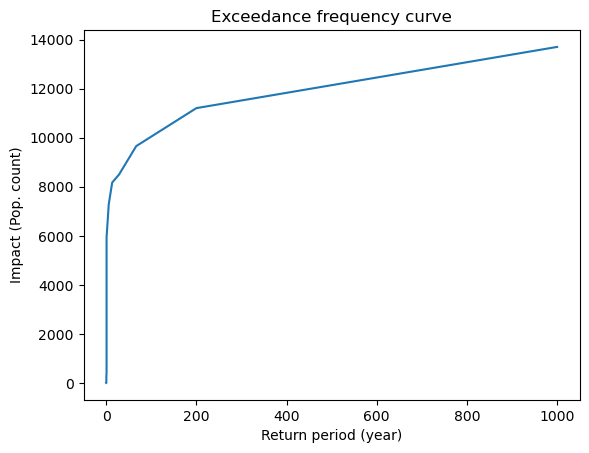

In [49]:
freqd_curve.plot()

<GeoAxes: title={'center': 'Expected annual impact'}>

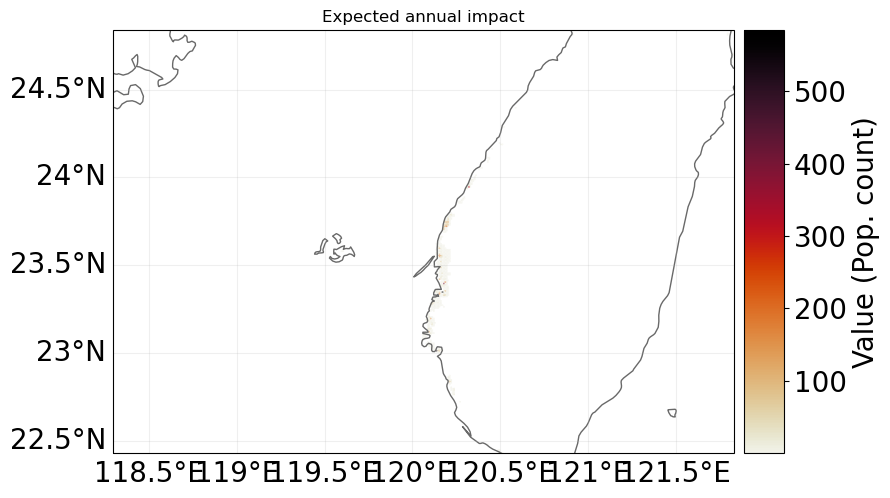

In [58]:
impact.plot_hexbin_eai_exposure(pop_name=False, ignore_zero=True)